# Keras - Callbacks

Construindo a rede. Após compilar o modelos, alguns metodos podem ser usados como por exemplo model.layer[1].input ou model.layer[1].output que mostra a camada ou as camadas de entrada e/ou de saída do modelo criado.

In [5]:
from tensorflow.keras.datasets import mnist
from tensorflow import keras
from keras import layers

def get_mnist_model():
    '''
    Para que seja possível visualizar o Summary só é possível com a camada Input OU
    fazendo o build sobre o modelo. Ter que fazer o build pe ruim porque se mudar a 
    quantidade de colunas da base de dados, o modelo teria que ser recompilado.
    Como estamos usando uma base de dados pronta 'mnist' estamos usando 28*28
    '''
    #camada 1 - input
    inputs = keras.Input(shape=(28*28))

    #camada 2 - features
    features = layers.Dense(512, activation="relu")(inputs)

    #camada 3 - reaproveitando variaveis features
    features = layers.Dropout(0.5)(features)

    outputs = layers.Dense(10, activation="softmax")(features)

    model = keras.Model(inputs, outputs)

    return model

Até agora o que estávamos fazendo?
Treinamos o modelo, olha até onde ele foi nas tentativas... treina de novo... mas sem considerar qual o melhor ponto de parada do treinamento. Ou seja, no momento em que o treinamento não for mais útil (começar a dar overfit), podemos parar.

Em outras palavras, quando o valor de acurácia da validação começar a subir divergindo do treino, podemos parar.

Também podemos salvar parciais do modelo treinado com checkpoint. Assim, podemos carregar o modelo parial já treinado e continuar a partir dele.

In [7]:
import numpy as np
from tensorflow.keras.utils import to_categorical

callbacks_list = [
    keras.callbacks.EarlyStopping(
    monitor="val_accuracy", #função a ser considerada no monitoramento para pararmos o treinamento
    patience=2),     #se aumentar a acurácia de validação duas vezes ele para

    keras.callbacks.ModelCheckpoint(filepath="checkpoint_path.keras",
                                monitor="val_loss",
                                save_best_only=True)]

c='''
Neste caso não binarizamos os dados, então podemos usar a loss-function sparse_categorical_crossentropy.
'''
epochs=20

(images, labels), (test_images, test_labels) = mnist.load_data()
images = images.reshape((60000, 28*28)).astype("float32")/255
test_images = test_images.reshape((10000, 28*28)).astype("float32")/255
train_images,val_images = images[10000:], images[:10000]
train_labels, val_labels = labels[10000:], labels[:10000]
model = get_mnist_model()
model.compile(optimizer = "rmsprop", loss="sparse_categorical_crossentropy", metrics="accuracy")
model.fit(train_images, train_labels, epochs=epochs,callbacks=callbacks_list, validation_data=(val_images, val_labels))
test_metrics = model.evaluate(test_images, test_labels)
predictions = model.predict(test_images)


Epoch 1/20
1563/1563 [==============================] - 16s 10ms/step - loss: 0.2933 - accuracy: 0.9126 - val_loss: 0.1435 - val_accuracy: 0.9604
Epoch 2/20
1563/1563 [==============================] - 16s 10ms/step - loss: 0.1665 - accuracy: 0.9526 - val_loss: 0.1239 - val_accuracy: 0.9664
Epoch 3/20
1563/1563 [==============================] - 16s 10ms/step - loss: 0.1377 - accuracy: 0.9621 - val_loss: 0.1145 - val_accuracy: 0.9728
Epoch 4/20
1563/1563 [==============================] - 16s 10ms/step - loss: 0.1267 - accuracy: 0.9671 - val_loss: 0.1110 - val_accuracy: 0.9736
Epoch 5/20
1563/1563 [==============================] - 16s 10ms/step - loss: 0.1166 - accuracy: 0.9710 - val_loss: 0.1144 - val_accuracy: 0.9755
Epoch 6/20
1563/1563 [==============================] - 17s 11ms/step - loss: 0.1115 - accuracy: 0.9725 - val_loss: 0.1106 - val_accuracy: 0.9763
Epoch 7/20
1563/1563 [==============================] - 16s 10ms/step - loss: 0.1034 - accuracy: 0.9756 - val_loss: 0.1159 -

Neste exemplo, vemos que o valor de accuracy caiu de 0.9837 para 0.9835; em seguida, houve uma segunda queda para 0.9810, nesse momento o EarlyStopping atuou e parou o treinamento, pois atingiu os 2 do parâmetro patience. Patience pode ser usado também monitorando a função de loss.

Passando adiante, podemos também criar nossa própria função de callback.

In [23]:
from matplotlib import pyplot as plt

class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs):
        self.per_batch_losses = [] #ok so isso
        self.per_val_losses = []

    def on_epoch_end(self, epoch, logs):
        self.per_batch_losses.append(logs.get("loss")) #ok so isso
        self.per_val_losses.append(logs.get("val_loss"))

    def on_train_end(self, logs):        
        plt.clf()
        #ok so isso
        plt.plot(range(len(self.per_batch_losses)),
                self.per_batch_losses,
                label="Training loss for each batch")
        #fimok

        #tentando imprimir duas metricas chamando os resultados direto daqui, sem os passos intermediarios preenchendo a lista
        plt.plot(range(len(self.per_val_losses)),
                self.per_val_losses,
                label="Training val_loss for each batch")
    
        #plt.xlabel(f"Batch(epoch{epoch})")
        plt.xlabel(f"Batch(epoch)")
        plt.ylabel("loss")
        plt.legend()
        #plt.savefig(f"plot_at_epoch_{epoch}")
        plt.show()
        self.per_batch_losses = []
        self.per_val_losses = []

Testando novamente chamando agora, ao inves dos callbacks anteriores, chamamos o HistoryLoss() para imprimir os arquivos conforme os checkpoints e mostrando os gráficos.

Epoch 1/10
1563/1563 [==============================] - 16s 10ms/step - loss: 0.2970 - accuracy: 0.9120 - val_loss: 0.1564 - val_accuracy: 0.9546
Epoch 2/10
1563/1563 [==============================] - 15s 10ms/step - loss: 0.1624 - accuracy: 0.9548 - val_loss: 0.1248 - val_accuracy: 0.9648
Epoch 3/10
1563/1563 [==============================] - 16s 10ms/step - loss: 0.1395 - accuracy: 0.9634 - val_loss: 0.1122 - val_accuracy: 0.9705
Epoch 4/10
1563/1563 [==============================] - 16s 10ms/step - loss: 0.1289 - accuracy: 0.9673 - val_loss: 0.1143 - val_accuracy: 0.9737
Epoch 5/10
1563/1563 [==============================] - 16s 10ms/step - loss: 0.1170 - accuracy: 0.9694 - val_loss: 0.1129 - val_accuracy: 0.9759
Epoch 6/10
1563/1563 [==============================] - 16s 10ms/step - loss: 0.1090 - accuracy: 0.9728 - val_loss: 0.1108 - val_accuracy: 0.9760
Epoch 7/10
1563/1563 [==============================] - 16s 10ms/step - loss: 0.1046 - accuracy: 0.9746 - val_loss: 0.1190 -

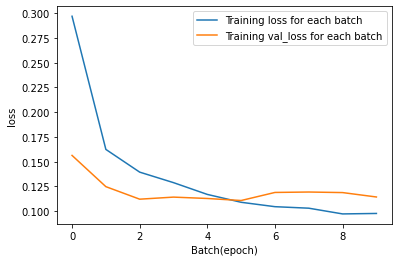

313/313 [==============================] - 1s 5ms/step - loss: 0.1077 - accuracy: 0.9794


In [25]:
epochs = 10

(images, labels), (test_images, test_labels) = mnist.load_data()
images = images.reshape((60000, 28*28)).astype("float32")/255
test_images = test_images.reshape((10000, 28*28)).astype("float32")/255
train_images,val_images = images[10000:], images[:10000]
train_labels, val_labels = labels[10000:], labels[:10000]
model = get_mnist_model()
model.compile(optimizer = "rmsprop", loss="sparse_categorical_crossentropy", metrics="accuracy")
model.fit(train_images, train_labels, epochs=epochs,callbacks=LossHistory(), validation_data=(val_images, val_labels))
test_metrics = model.evaluate(test_images, test_labels)
predictions = model.predict(test_images)